In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import math
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import datetime as dt
%matplotlib inline
import os
import sys
from tqdm import tqdm
sys.path.append('/home/basil/Desktop/cape_mend_SM_LCS/datatools')
import datatools as tools
import cmocean as cm
from scipy.interpolate import griddata

In [3]:
to_hd = '/media/basil/Elements/data/'
data_files, data_filepath = tools.get_data_paths_from_binary(to_hd,'Fram',file_end='nc')
data = xr.open_mfdataset(data_filepath[-2])
data_test = data.isel(TIME=0,STATION=0)
lat_sampled = data_test['LATITUDE']
lon_sampled = data_test['LONGITUDE']

ValueError: Dimensions {'STATION', 'TIME'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'time': 172, 'x': 25, 'k': 56})

In [3]:
llc270_data = '/media/basil/Elements/data/llc270/'

model_uv_files, model_uv_filepath = tools.get_data_paths_from_binary(llc270_data,'VEL_corrected',file_end='nc')
uv_model = xr.open_mfdataset(model_uv_filepath)

In [4]:
uv_model = uv_model.drop_vars({'timestep'}).isel(tile=6)

In [8]:
grid_270 = xr.open_dataset(to_hd+'llc270/llc270_grid_test.nc')

In [12]:
grid_270 = xr.open_dataset(to_hd+'llc270/Grid/GRID.0007.nc')
grid_270 = grid_270.rename({'i2':'j','i3':'i','i1':'k'})
grid_270['i'] = (grid_270['i']-1).astype(int)
grid_270['j'] = (grid_270['j']-1).astype(int)
grid_270['k'] = (grid_270['k'] -1).astype(int)

In [6]:
model_gridded = xr.merge([uv_model,grid.isel(tile=6)]).set_coords({'XC','YC'})


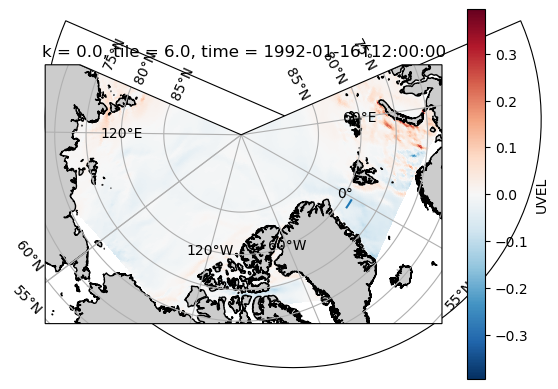

In [26]:
proj = ccrs.LambertConformal()
ax = plt.axes(projection=proj)
ax = plt.axes(projection=proj)
coast_10m = cfeature.NaturalEarthFeature("physical", "land", "10m", edgecolor="k", facecolor="0.8")

ax.add_feature(coast_10m)
gl = ax.gridlines(draw_labels=True)
model_gridded['UVEL'].isel(time=0,k=0).plot(x='XC',y='YC',transform=ccrs.PlateCarree())
plt.plot(lon_sampled,lat_sampled,transform=ccrs.PlateCarree())

In [7]:
transect_lon = lon_sampled
transect_lat = lat_sampled
lat_cut = model_gridded.where(np.logical_and(transect_lat.max()+.5>model_gridded.YC,transect_lat.min()-.5<model_gridded.YC))
lon_cut = lat_cut.where(np.logical_and(transect_lon.max()+.5>lat_cut.XC,transect_lon.min()-.5<lat_cut.XC))
tran_cut = lon_cut.dropna(how='all',dim='i').dropna(how='all',dim='j')
lon = tran_cut.XC
lat = tran_cut.YC
Lon, Lat = lon,lat
points = np.column_stack([np.ravel(Lon), np.ravel(Lat)])

In [8]:
tran_cut = tran_cut.sel(time=slice('2003-09','2017-12')).set_coords({'XC','YC'})
tran_cut

<xarray.Dataset>
Dimensions:  (time: 172, k: 50, i: 12, j: 9)
Coordinates:
  * i        (i) float32 148.0 149.0 150.0 151.0 ... 156.0 157.0 158.0 159.0
  * j        (j) float32 45.0 46.0 47.0 48.0 49.0 50.0 51.0 52.0 53.0
  * k        (k) float32 0.0 1.0 2.0 3.0 4.0 5.0 ... 45.0 46.0 47.0 48.0 49.0
    tile     float64 6.0
  * time     (time) datetime64[ns] 2003-09-16 ... 2017-12-16T12:00:00
    XC       (i, j) float32 -1.352 -1.447 -1.545 -1.644 ... -8.998 -9.187 -9.38
    YC       (i, j) float32 78.45 78.58 78.72 78.85 ... 78.84 78.98 79.11 79.24
    STATION  float32 nan
    TIME     datetime64[ns] 2003-09-15T00:00:01.000004608
Data variables:
    UVEL     (time, k, i, j) float32 dask.array<chunksize=(4, 50, 12, 9), meta=np.ndarray>
    VVEL     (time, k, i, j) float32 dask.array<chunksize=(4, 50, 12, 9), meta=np.ndarray>
    DXC      (i, j) float32 nan nan 1.523e+04 1.52e+04 ... nan nan nan nan
    DXG      (i, j) float32 nan nan 1.522e+04 1.518e+04 ... nan nan nan nan
    DYC      (i, j) float32 nan nan 1.373e+04 1.372e+04 ... nan nan nan nan
    DYG      (i, j) float32 nan nan 1.373e+04 1.372e+04 ... nan nan nan nan
    Depth    (i, j) float32 nan nan 2.679e+03 2.604e+03 ... nan nan nan nan
    RAC      (i, j) float32 nan nan 2.088e+08 2.083e+08 ... nan nan nan nan
    RAZ      (i, j) float32 nan nan 2.091e+08 2.086e+08 ... nan nan nan nan
    XG       (i, j) float32 nan nan -1.185 -1.28 -1.377 ... nan nan nan nan nan
    YG       (i, j) float32 nan nan 78.66 78.79 78.93 ... nan nan nan nan nan
    hFacC    (k, i, j) float64 nan nan 1.0 1.0 1.0 1.0 ... nan nan nan nan nan

In [28]:
data_subsample = xr.open_mfdataset(data_filepath[-1])
data_subsample

<xarray.Dataset>
Dimensions:           (time: 172, x: 25, k: 56)
Coordinates:
    depth             (x, k, time) float64 dask.array<chunksize=(25, 56, 172), meta=np.ndarray>
  * x                 (x) int64 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23 24
  * time              (time) datetime64[ns] 2003-09-16 ... 2017-12-16T12:00:00
Dimensions without coordinates: k
Data variables:
    Salinity_1080     (time, x, k) float64 dask.array<chunksize=(172, 25, 56), meta=np.ndarray>
    Temperature_1080  (time, x, k) float64 dask.array<chunksize=(172, 25, 56), meta=np.ndarray>
    Salinity_270      (time, x, k) float64 dask.array<chunksize=(172, 25, 56), meta=np.ndarray>
    Temperature_270   (time, x, k) float64 dask.array<chunksize=(172, 25, 56), meta=np.ndarray>
    Salinity_obs      (x, k, time) float64 dask.array<chunksize=(25, 56, 172), meta=np.ndarray>
    Temperature_obs   (x, k, time) float64 dask.array<chunksize=(25, 56, 172), meta=np.ndarray>
    Velocity_obs      (x, k, time) float64 dask.array<chunksize=(25, 56, 172), meta=np.ndarray>

In [9]:
grid_depth = xr.open_dataset('/media/basil/Elements/data/llc270/Grid/GRID.0007.nc')

grid_depth = grid_depth.rename({'i2':'j','i3':'i','i1':'k'})
grid_depth['i'] = (grid_depth['i']-1).astype(int)
grid_depth['j'] = (grid_depth['j']-1).astype(int)
grid_depth['k'] = (grid_depth['k'] -1).astype(int)
RC = np.array(grid_depth['RC'])

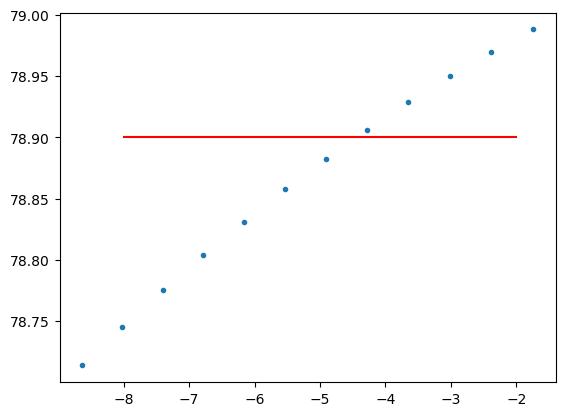

In [36]:
a=4
plt.plot(tran_cut['UVEL'].isel(k=0,time=0,j=a).XC,tran_cut['UVEL'].isel(k=0,time=0,j=a).YC, '.')#.plot(x='XC',y='YC')
plt.plot(lon_sampled,lat_sampled,'r')



In [44]:
transect_lon_rot_270 = tran_cut['UVEL'].isel(k=0,time=0,j=a).XC[1:]
transect_lat_rot_270 = tran_cut['UVEL'].isel(k=0,time=0,j=a).YC[1:]

x_hat = np.diff(transect_lon_rot_270)
y_hat = np.diff(transect_lat_rot_270)
deg_shift = np.arctan(y_hat/x_hat)

deg_shift = np.append(deg_shift,deg_shift.mean())
deg_shift = deg_shift*180/(2*np.pi)

deg_tran_270 = np.interp(np.arange(25),np.arange(11),deg_shift)
deg_tran_270

array([0.89244169, 0.95406067, 1.01560545, 1.07745278, 1.14033198,
       1.2032392 , 1.26619923, 1.33030164, 1.39452302, 1.45924985,
       1.17334056, 1.17334056, 1.17334056, 1.17334056, 1.17334056,
       1.17334056, 1.17334056, 1.17334056, 1.17334056, 1.17334056,
       1.17334056, 1.17334056, 1.17334056, 1.17334056, 1.17334056])

11

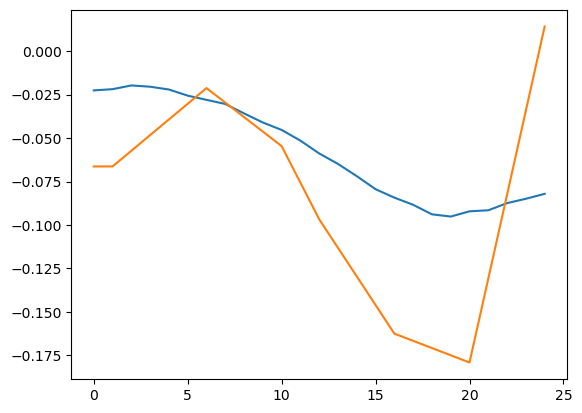

In [42]:
i=0
j=5
tran_cut_time_k = tran_cut.isel(time=i,k=j)
time = [np.array(tran_cut_time_k.time)]
k_num = [np.array(RC[j])]
sampled_transect_v = griddata(points, np.array(tran_cut_time_k['UVEL']).ravel(), (transect_lon, transect_lat))
plt.plot(data_subsample.x,sampled_transect_v)
plt.plot(data_subsample.x,data_subsample.isel(k=j,time=i)['Velocity_obs'])

In [43]:
for i in tqdm(range(0,len(tran_cut.time))):
    for j in range(0,len(tran_cut['k'])):
        tran_cut_time_k = tran_cut.isel(time=i,k=j)
        time = [np.array(tran_cut_time_k.time)]
        k_num = [np.array(RC[j])]
        sampled_transect_u = griddata(points, np.array(tran_cut_time_k['UVEL']).ravel(), (transect_lon, transect_lat))
        sampled_transect_v = griddata(points, np.array(tran_cut_time_k['VVEL']).ravel(), (transect_lon, transect_lat))
        sampled_transect_u = np.reshape(sampled_transect_u, (1,1,len(transect_lon)))
        sampled_transect_v = np.reshape(sampled_transect_v, (1,1,len(transect_lon)))
        u_data = xr.DataArray(sampled_transect_u ,coords=[time,k_num,data_subsample.x],dims=['time','depth','x'],name='u')
        v_data = xr.DataArray(sampled_transect_v,coords=[time,k_num,data_subsample.x],dims=['time','depth','x'],name='v')
        u_data.to_netcdf(llc270_data+'fram-subsample/U/U_'+str(i).zfill(4)+'_'+str(j).zfill(2)+'.nc')
        v_data.to_netcdf(llc270_data+'fram-subsample/V/V_'+str(i).zfill(4)+'_'+str(j).zfill(2)+'.nc')

100%|███████████████████████████████████████| 172/172 [1:33:41<00:00, 32.68s/it]


In [49]:
llc270_data = '/media/basil/Elements/data/llc270/'

llc270_files_u, llc270_filepath_u = tools.get_data_paths_from_binary(llc270_data,'fram-subsample/U',file_end='nc')
llc270_files_v, llc270_filepath_v = tools.get_data_paths_from_binary(llc270_data,'fram-subsample/V',file_end='nc')
uv_270_sub = xr.open_mfdataset(llc270_filepath_u+llc270_filepath_v)

<xarray.Dataset>
Dimensions:  (time: 172, depth: 50, x: 25)
Coordinates:
  * time     (time) datetime64[ns] 2003-09-16 ... 2017-12-16T12:00:00
  * depth    (depth) float64 -5.906e+03 -5.461e+03 -5.039e+03 ... -15.0 -5.0
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 ... 15 16 17 18 19 20 21 22 23 24
Data variables:
    u        (time, depth, x) float64 dask.array<chunksize=(1, 1, 25), meta=np.ndarray>
    v        (time, depth, x) float64 dask.array<chunksize=(1, 1, 25), meta=np.ndarray>

In [45]:
llc1080_path = '/media/basil/Elements/data/N_Greenland/solution_output/'
llc1080_files, llc1080_filepath = tools.get_data_paths_from_binary(llc1080_path,'llc_1080_vel/uv_files',file_end='nc')
data_1080 = xr.open_mfdataset(llc1080_filepath).set_coords({'longitude','latitude'})

In [46]:
llc1080_data = data_1080
transect_lon = np.array(lon_sampled)
transect_lat = np.array(lat_sampled)
lat_cut = llc1080_data.where(np.logical_and(transect_lat.max()+.5>llc1080_data.latitude,transect_lat.min()-.5<llc1080_data.latitude))
lon_cut = lat_cut.where(np.logical_and(transect_lon.max()+.5>lat_cut.longitude,transect_lon.min()-.5<lat_cut.longitude))
tran_cut = lon_cut.dropna(how='all',dim='rows').dropna(how='all',dim='cols')
lon = tran_cut.longitude
lat = tran_cut.latitude
Lon, Lat = lon,lat

In [47]:
lon = tran_cut.longitude.isel(iterations=0)
lat = tran_cut.latitude.isel(iterations=0)
Lon, Lat = lon,lat


In [10]:
tran_cut

<xarray.Dataset>
Dimensions:     (iterations: 264, rows: 49, cols: 36, depths: 50)
Coordinates:
  * iterations  (iterations) float32 8.415e+05 8.505e+05 ... 3.138e+06 3.147e+06
    longitude   (iterations, rows, cols) float32 dask.array<chunksize=(1, 49, 36), meta=np.ndarray>
    latitude    (iterations, rows, cols) float32 dask.array<chunksize=(1, 49, 36), meta=np.ndarray>
  * depths      (depths) float32 5.0 15.0 25.0 ... 5.039e+03 5.461e+03 5.906e+03
Dimensions without coordinates: rows, cols
Data variables:
    time        (iterations, rows, cols) float32 dask.array<chunksize=(1, 49, 36), meta=np.ndarray>
    Uvel        (iterations, depths, rows, cols) float32 dask.array<chunksize=(1, 50, 49, 36), meta=np.ndarray>
    Vvel        (iterations, depths, rows, cols) float32 dask.array<chunksize=(1, 50, 49, 36), meta=np.ndarray>

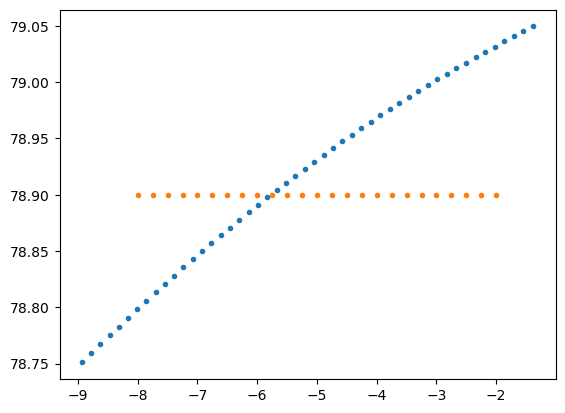

In [169]:
transect_lon_rot_1080 = tran_cut['Uvel'].isel(iterations=0,depths=0,cols=18).longitude
transect_lat_rot_1080 = tran_cut['Uvel'].isel(iterations=0,depths=0,cols=18).latitude
plt.plot(transect_lon_rot_1080,transect_lat_rot_1080, '.')#.plot(x='longitude',y='latitude')
plt.plot(transect_lon,transect_lat,'.')

In [63]:
x_hat = np.diff(transect_lon_rot_1080[8:-6])
y_hat = np.diff(transect_lat_rot_1080[8:-6])
deg_shift = np.arctan(y_hat/x_hat)

deg_shift = np.append(deg_shift,deg_shift.mean())
deg_shift = deg_shift*180/(2*np.pi)

deg_tran_1080 = np.interp(np.arange(25),np.arange(len(deg_shift)),deg_shift)
deg_tran_1080
deg_tran_270

array([0.89244169, 0.95406067, 1.01560545, 1.07745278, 1.14033198,
       1.2032392 , 1.26619923, 1.33030164, 1.39452302, 1.45924985,
       1.17334056, 1.17334056, 1.17334056, 1.17334056, 1.17334056,
       1.17334056, 1.17334056, 1.17334056, 1.17334056, 1.17334056,
       1.17334056, 1.17334056, 1.17334056, 1.17334056, 1.17334056])

In [12]:
data.LON

<xarray.DataArray 'LON' (LON: 25)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])
Dimensions without coordinates: LON

In [15]:
points = np.column_stack([np.ravel(Lon), np.ravel(Lat)])

for i in tqdm(range(0,len(tran_cut.iterations))):
    for j in range(0,len(tran_cut['depths'])):
        tran_cut_time_k = tran_cut.isel(iterations=i,depths=j)
        year = llc1080_files[i].split('.')[1][0:4]
        month = llc1080_files[i].split('.')[1][4:6]
        day = 15
        time = [datetime(int(year),int(month),int(day))]        
        k_num = [np.array(tran_cut['depths'])[j]]
        sampled_transect_u = griddata(points, np.array(tran_cut_time_k['Uvel']).ravel(), (transect_lon, transect_lat))
        sampled_transect_v = griddata(points, np.array(tran_cut_time_k['Vvel']).ravel(), (transect_lon, transect_lat))
        sampled_transect_u = np.reshape(sampled_transect_u, (1,1,len(transect_lon)))
        sampled_transect_v = np.reshape(sampled_transect_v, (1,1,len(transect_lon)))
        u_data = xr.DataArray(sampled_transect_u ,coords=[time,k_num,data.LON],dims=['time','depth','x'],name='u_1080')
        v_data = xr.DataArray(sampled_transect_v,coords=[time,k_num,data.LON],dims=['time','depth','x'],name='v_1080')
        u_data.to_netcdf(llc1080_path+'llc_1080_vel/uv_files/U/U_'+str(i).zfill(4)+'_'+str(j).zfill(2)+'.nc')
        v_data.to_netcdf(llc1080_path+'llc_1080_vel/uv_files/V/V_'+str(i).zfill(4)+'_'+str(j).zfill(2)+'.nc')

100%|███████████████████████████████████████| 264/264 [2:37:01<00:00, 35.69s/it]


In [48]:
llc1080_path = '/media/basil/Elements/data/N_Greenland/solution_output/'

llc1080_files_u, llc1080_filepath_u = tools.get_data_paths_from_binary(llc1080_path,'llc_1080_vel/uv_files/U',file_end='nc')
llc1080_files_v, llc1080_filepath_v = tools.get_data_paths_from_binary(llc1080_path,'llc_1080_vel/uv_files/V',file_end='nc')
uv_1080_sub = xr.open_mfdataset(llc1080_filepath_u+llc1080_filepath_v).sel(time=slice('2003-09','2017-12'))

In [59]:
#uv_1080_sub.sel(time=slice('2003-09','2017-12'))
uv_270_sub.interp(depth=fram_sub['depth'])
uv_1080_sub.interp(depth=fram_sub['depth'])
fram_sub

<xarray.Dataset>
Dimensions:           (time: 172, x: 25, k: 56)
Coordinates:
    depth             (x, k, time) float64 ...
  * x                 (x) int64 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23 24
  * time              (time) datetime64[ns] 2003-09-16 ... 2017-12-16T12:00:00
Dimensions without coordinates: k
Data variables:
    Salinity_1080     (time, x, k) float64 ...
    Temperature_1080  (time, x, k) float64 ...
    Salinity_270      (time, x, k) float64 ...
    Temperature_270   (time, x, k) float64 ...
    Salinity_obs      (x, k, time) float64 ...
    Temperature_obs   (x, k, time) float64 ...
    Velocity_obs      (x, k, time) float64 ...

In [42]:
fram_sub = xr.open_dataset('/media/basil/Elements/data/Fram/fram_model_and_obs_subsample.nc')

In [105]:
fram_sub_uv_ts = xr.merge([fram_sub,uv_270_sub.interp(depth=fram_sub['depth']).rename({'u':'u_270','v':'v_270'}),uv_1080_sub.interp(depth=fram_sub['depth']*-1)])

In [ ]:
def great_circle_distance(lon_ref, lat_ref, Lon, Lat):
    earth_radius = 6371000
    lon_ref_radians = np.radians(lon_ref)
    lat_ref_radians = np.radians(lat_ref)
    lons_radians = np.radians(Lon)
    lats_radians = np.radians(Lat)
    lat_diff = lats_radians - lat_ref_radians
    lon_diff = lons_radians - lon_ref_radians
    d = np.sin(lat_diff * 0.5) ** 2 + np.cos(lat_ref_radians) * np.cos(lats_radians) * np.sin(lon_diff * 0.5) ** 2
    h = 2 * earth_radius * np.arcsin(np.sqrt(d))
    return(h)

In [106]:
fram_sub_uv_ts

<xarray.Dataset>
Dimensions:           (time: 172, x: 25, k: 56)
Coordinates:
    depth             (x, k, time) float64 -5.056 -5.056 ... -2.737e+03
  * x                 (x) int64 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23 24
  * time              (time) datetime64[ns] 2003-09-16 ... 2017-12-16T12:00:00
Dimensions without coordinates: k
Data variables:
    Salinity_1080     (time, x, k) float64 ...
    Temperature_1080  (time, x, k) float64 ...
    Salinity_270      (time, x, k) float64 ...
    Temperature_270   (time, x, k) float64 ...
    Salinity_obs      (x, k, time) float64 ...
    Temperature_obs   (x, k, time) float64 ...
    Velocity_obs      (x, k, time) float64 ...
    u_270             (time, x, k) float64 dask.array<chunksize=(172, 25, 56), meta=np.ndarray>
    v_270             (time, x, k) float64 dask.array<chunksize=(172, 25, 56), meta=np.ndarray>
    u_1080            (time, x, k) float64 dask.array<chunksize=(172, 25, 56), meta=np.ndarray>
    v_1080            (time, x, k) float64 dask.array<chunksize=(172, 25, 56), meta=np.ndarray>

In [64]:
def rot(u,v,theta):
    """
Rotate a vector counter-clockwise OR rotate the coordinate system clockwise.

Usage:
ur,vr = rot(u,v,theta)

Input:
u,v - vector components (e.g. u = eastward velocity, v = northward velocity)
theta - rotation angle (degrees)

Output:
ur,vr - rotated vector components

Example:
rot(1,0,90) returns (0,1)
    """

    # Make sure inputs are numpy arrays
    if type(u) is list:
        u = np.array(u)
        v = np.array(v)

    w = u + 1j*v            # complex vector
    ang = theta*np.pi/180   # convert angle to radians
    wr = w*np.exp(1j*ang)  # complex vector rotation
    ur = np.real(wr)        # return u and v components
    vr = np.imag(wr)
    return ur,vr


In [126]:
np.shape(fram_sub_uv_ts[['time','k','x','u_270','v_270','u_1080','v_1080']]['u_1080'])
deg_tran_1080_1 = np.reshape(deg_tran_1080,(25))
deg_tran_270_1 = np.reshape(deg_tran_270,(25))

deg_tran_1080_1 = np.ones(56)*deg_tran_1080_1[::,None]
deg_tran_270_1 = np.ones(56)*deg_tran_270_1[::,None]

In [198]:
degree_full_1080 = np.full((172,25,56),deg_tran_1080_1)
degree_full_270 = np.full((172,25,56),deg_tran_270_1)

ur_1080,vr_1080 = rot(fram_sub_uv_ts['u_1080'],fram_sub_uv_ts['v_1080'],degree_full_1080)
ur_270, vr_270 = rot(fram_sub_uv_ts['u_270'],fram_sub_uv_ts['v_270'],degree_full_270)

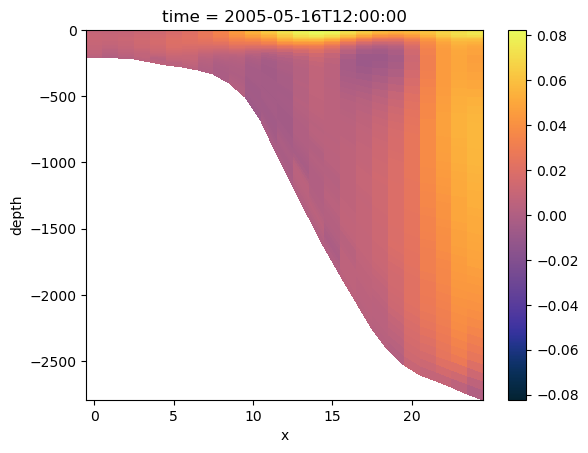

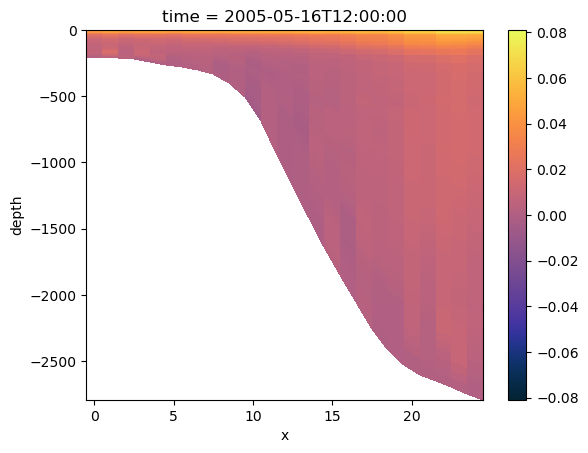

In [128]:
(vr_1080.isel(time=20)).plot(x='x',y='depth',cmap=cm.cm.thermal)
plt.show()
(vr_270.isel(time=20)).plot(x='x',y='depth',cmap=cm.cm.thermal)


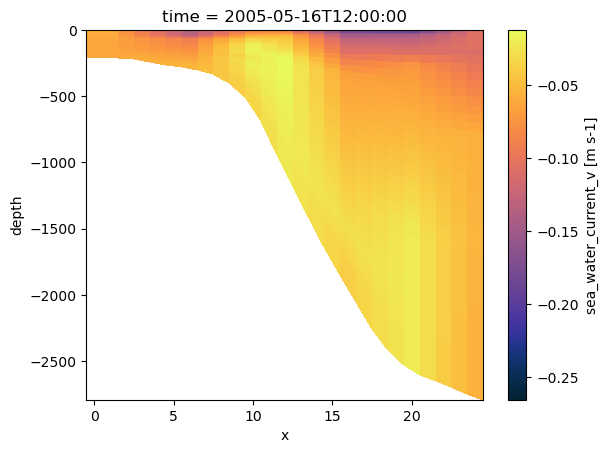

In [129]:
fram_sub_uv_ts.isel(time=20)['Velocity_obs'].plot(x='x',y='depth',cmap=cm.cm.thermal)

In [199]:
fram_sub_uv_ts['Velocity_270'] = vr_270
fram_sub_uv_ts['Velocity_1080'] = vr_1080

In [137]:
x = fram_sub_uv_ts.x
k = fram_sub_uv_ts.k

In [133]:
fram_sub_uv_ts.to_netcdf('/media/basil/Elements/data/Fram/full_subsample_fram.nc')

In [4]:
full_data = xr.open_dataset('/media/basil/Elements/data/Fram/full_subsample_fram.nc')

In [6]:
grid_1080 = xr.open_dataset('/media/basil/Elements/data/N_Greenland/L1_N_Greenland_grid.nc')

<xarray.Dataset>
Dimensions:           (time: 172, x: 25, k: 56)
Coordinates:
    depth             (x, k, time) float64 ...
  * time              (time) datetime64[ns] 2003-09-16 ... 2017-12-16T12:00:00
  * x                 (x) float64 0.0 5.35e+03 1.07e+04 ... 1.23e+05 1.284e+05
  * k                 (k) int64 0 1 2 3 4 5 6 7 8 ... 47 48 49 50 51 52 53 54 55
Data variables: (12/14)
    Salinity_1080     (time, x, k) float64 ...
    Temperature_1080  (time, x, k) float64 ...
    Salinity_270      (time, x, k) float64 ...
    Temperature_270   (time, x, k) float64 ...
    Salinity_obs      (x, k, time) float64 ...
    Temperature_obs   (x, k, time) float64 ...
    ...                ...
    v_270             (time, x, k) float64 ...
    u_1080            (time, x, k) float64 ...
    v_1080            (time, x, k) float64 ...
    Velocity_270      (time, x, k) float64 ...
    Velocity_1080     (time, x, k) float64 ...
    area              (x, k) float64 ...

In [7]:
#got to subsample this: 1080 and 270 grids

medional_velocity = AngleSN * Uvel + AngleCS * Vvel

<xarray.Dataset>
Dimensions:  (Y: 720, X: 720, Xp1: 721, Yp1: 721, Z: 50)
Dimensions without coordinates: Y, X, Xp1, Yp1, Z
Data variables: (12/16)
    XC       (Y, X) float32 ...
    YC       (Y, X) float32 ...
    XG       (Y, X) float32 ...
    YG       (Y, X) float32 ...
    AngleCS  (Y, X) float32 ...
    AngleSN  (Y, X) float32 ...
    ...       ...
    HFacC    (Z, Y, X) float32 ...
    HFacW    (Z, Y, Xp1) float32 ...
    HFacS    (Z, Yp1, X) float32 ...
    drF      (Z) float32 ...
    Depth    (Y, X) float32 ...
    rA       (Y, X) float32 ...

In [5]:
full_data


<xarray.Dataset>
Dimensions:           (time: 172, x: 25, k: 56)
Coordinates:
    depth             (x, k, time) float64 ...
  * time              (time) datetime64[ns] 2003-09-16 ... 2017-12-16T12:00:00
  * x                 (x) float64 0.0 5.35e+03 1.07e+04 ... 1.23e+05 1.284e+05
  * k                 (k) int64 0 1 2 3 4 5 6 7 8 ... 47 48 49 50 51 52 53 54 55
Data variables: (12/14)
    Salinity_1080     (time, x, k) float64 ...
    Temperature_1080  (time, x, k) float64 ...
    Salinity_270      (time, x, k) float64 ...
    Temperature_270   (time, x, k) float64 ...
    Salinity_obs      (x, k, time) float64 ...
    Temperature_obs   (x, k, time) float64 ...
    ...                ...
    v_270             (time, x, k) float64 ...
    u_1080            (time, x, k) float64 ...
    v_1080            (time, x, k) float64 ...
    Velocity_270      (time, x, k) float64 ...
    Velocity_1080     (time, x, k) float64 ...
    area              (x, k) float64 ...

In [200]:
depth = np.array(fram_sub_uv_ts.isel(time=0).depth)
depth = xr.DataArray(depth,coords = [x,k],dims=['x','k'],name='depth')
error_v_1080 = (fram_sub_uv_ts['Velocity_obs']-fram_sub_uv_ts['Velocity_1080']).mean(dim='time').rename('error_v_1080')
error_v_270 = (fram_sub_uv_ts['Velocity_obs']- fram_sub_uv_ts['Velocity_270']).mean(dim='time').rename('error_v_270')
error_s_1080 = (fram_sub_uv_ts['Salinity_obs']-fram_sub_uv_ts['Salinity_1080']).mean(dim='time').rename('error_s_1080')
error_s_270 = (fram_sub_uv_ts['Salinity_obs']- fram_sub_uv_ts['Salinity_270']).mean(dim='time').rename('error_s_270')
error_t_270 = (fram_sub_uv_ts['Temperature_obs']- fram_sub_uv_ts['Temperature_270']).mean(dim='time').rename('error_t_270')
error_t_1080 = (fram_sub_uv_ts['Temperature_obs']-fram_sub_uv_ts['Temperature_1080']).mean(dim='time').rename('error_t_1080')

error = xr.merge([error_v_270,error_v_1080,error_s_270,error_s_1080,error_t_270,error_t_1080, depth])

In [201]:
error = error.set_coords('depth')

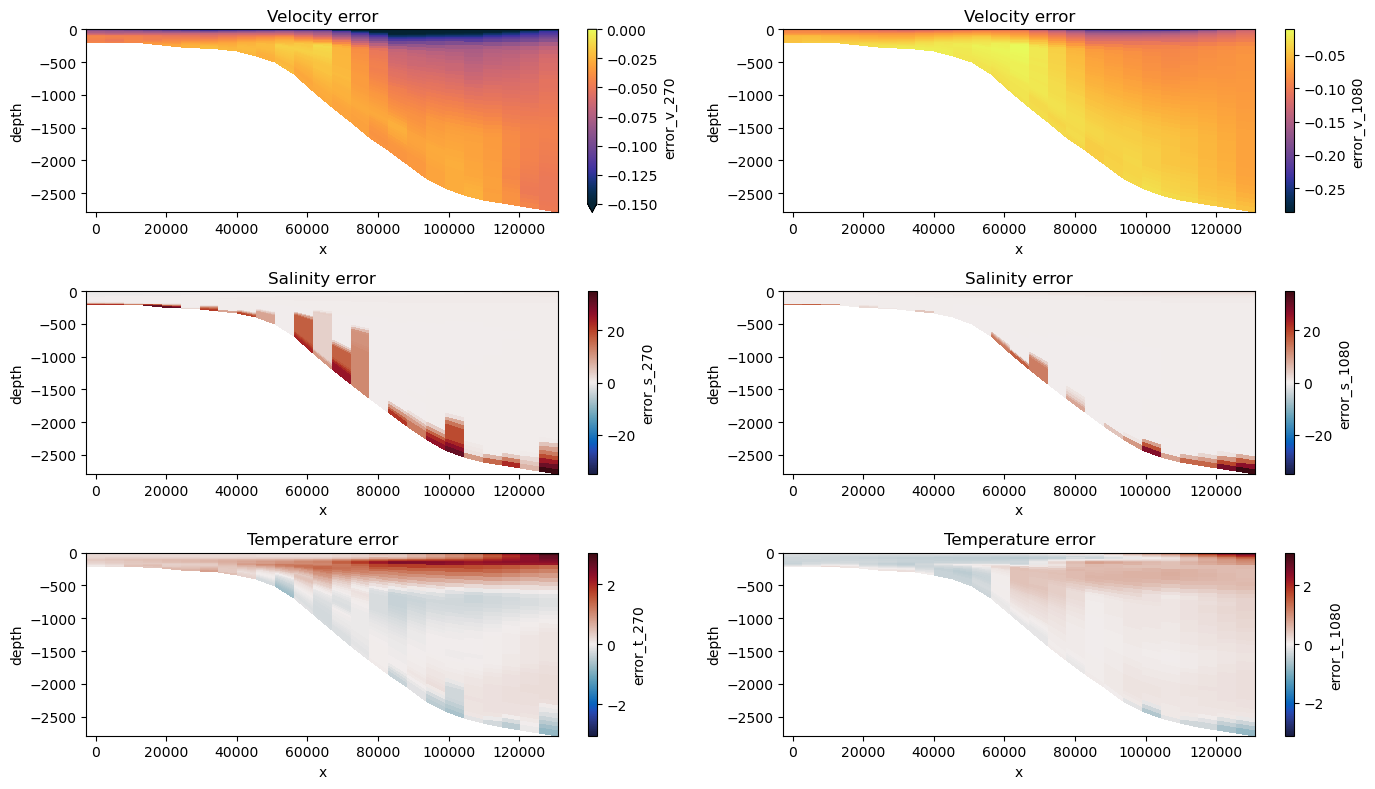

In [202]:
fig,ax = plt.subplots(ncols=2, nrows=3,figsize=(14,8))
error['error_v_270'].plot(x='x',y='depth',ax=ax[0,0],cmap = cm.cm.thermal,vmin=-.15,vmax=0)
error['error_v_1080'].plot(x='x',y='depth',ax=ax[0,1],cmap = cm.cm.thermal)
error['error_s_270'].plot(x='x',y='depth',ax=ax[1,0],cmap = cm.cm.balance)
error['error_s_1080'].plot(x='x',y='depth',ax=ax[1,1],cmap = cm.cm.balance)
error['error_t_270'].plot(x='x',y='depth',ax=ax[2,0],cmap = cm.cm.balance)
error['error_t_1080'].plot(x='x',y='depth',ax=ax[2,1],cmap = cm.cm.balance)
ax[0,0].set_title('Velocity error')
ax[0,1].set_title('Velocity error')
ax[1,0].set_title('Salinity error')
ax[1,1].set_title('Salinity error')
ax[2,0].set_title('Temperature error')
ax[2,1].set_title('Temperature error')
plt.tight_layout()
plt.savefig('./fram_velocity_error.png')

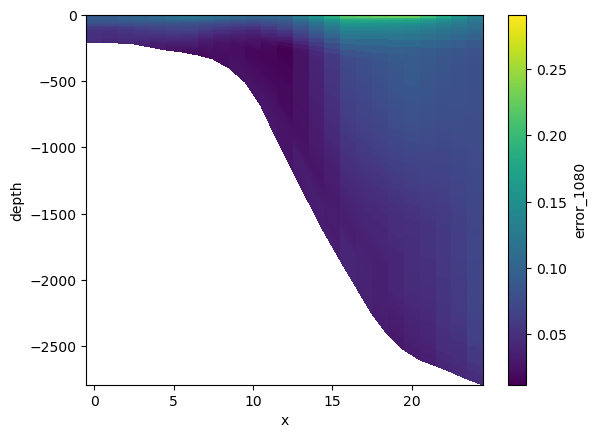

In [160]:
def great_circle_distance(lon_ref, lat_ref, Lon, Lat):
    earth_radius = 6371000
    lon_ref_radians = np.radians(lon_ref)
    lat_ref_radians = np.radians(lat_ref)
    lons_radians = np.radians(Lon)
    lats_radians = np.radians(Lat)
    lat_diff = lats_radians - lat_ref_radians
    lon_diff = lons_radians - lon_ref_radians
    d = np.sin(lat_diff * 0.5) ** 2 + np.cos(lat_ref_radians) * np.cos(lats_radians) * np.sin(lon_diff * 0.5) ** 2
    h = 2 * earth_radius * np.arcsin(np.sqrt(d))
    return(h)

In [161]:
transect_lon[0]
transect_lat[0]
tot_dist = great_circle_distance(transect_lon[0],transect_lat[0],transect_lon[-1],transect_lat[-1])

In [163]:
tot_dist
x = np.linspace(0,tot_dist,25)

tot_dist

In [ ]:
tot_dist/25

In [167]:
fram_sub_uv_ts.coords['x'] = x
fram_sub_uv_ts.coords['x'].attrs['units'] = 'm'

In [177]:
dd = np.append(np.array(fram_sub_uv_ts.isel(time=0)['depth'].diff(dim='k')),np.array(fram_sub_uv_ts.isel(time=0)['depth'].diff(dim='k').isel(k=54)))

In [182]:
dz = np.reshape(dd,(25,56))

In [183]:
dz = xr.DataArray(dz, coords=[x,k],dims=['x','k'],name='dz')

In [185]:
fram_sub_uv_ts['area'] = (tot_dist/25)*dz*-1

In [203]:
ds = fram_sub_uv_ts
area = ds['area']
sal_270 = ds['Salinity_270']
sal_1080 = ds['Salinity_1080']
sal_obs = ds['Salinity_obs']
temp_270 = ds['Temperature_270']
temp_1080 = ds['Temperature_1080']
temp_obs = ds['Temperature_obs']
vel_obs = ds['Velocity_obs']
vel_270 = ds['Velocity_270']
vel_1080 = ds['Velocity_1080']
sal_flux_270 = area*sal_270*vel_270
sal_flux_1080 = area*sal_1080*vel_1080
sal_flux_obs = area*sal_obs*vel_obs
temp_flux_270 = area*temp_270*vel_270
temp_flux_1080 = area*temp_1080*vel_1080
temp_flux_obs = area*temp_obs*vel_obs

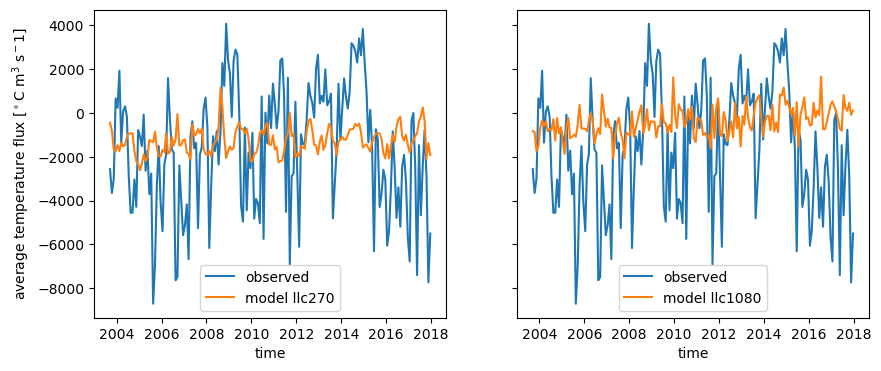

In [204]:
fig,ax = plt.subplots(ncols=2, nrows=1,figsize=(10,4),sharex=True,sharey=True,)

temp_flux_obs.mean(dim='k',skipna=True).mean(dim='x',skipna=True).plot(ax=ax[0],label='observed')
temp_flux_obs.mean(dim='k',skipna=True).mean(dim='x',skipna=True).plot(ax=ax[1],label='observed')

temp_flux_1080.mean(dim='k',skipna=True).mean(dim='x',skipna=True).plot(ax=ax[1],label='model llc1080')
temp_flux_270.mean(dim='k',skipna=True).mean(dim='x',skipna=True).plot(ax=ax[0],label='model llc270')
ax[0].set_ylabel('average temperature flux [$^\circ$C m$^3$ s$^-1$]')
ax[0].legend()
ax[1].legend()
plt.savefig('./temp_flux_ave_fram.png')

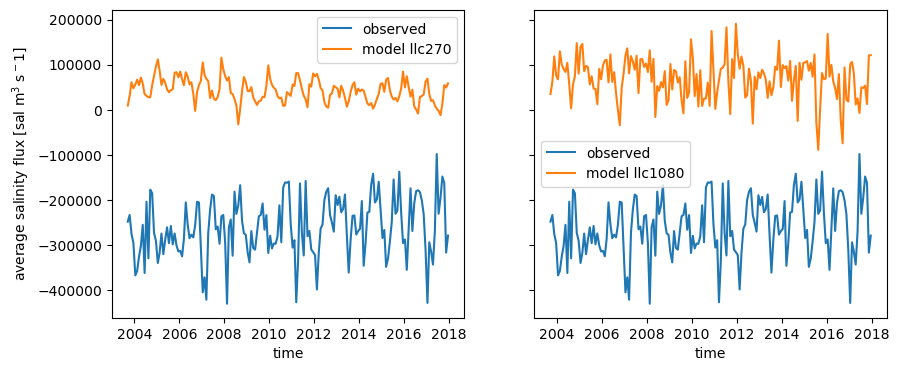

In [205]:
fig,ax = plt.subplots(ncols=2, nrows=1,figsize=(10,4),sharex=True,sharey=True,)

sal_flux_obs.mean(dim='k',skipna=True).mean(dim='x',skipna=True).plot(ax=ax[0],label='observed')
sal_flux_obs.mean(dim='k',skipna=True).mean(dim='x',skipna=True).plot(ax=ax[1],label='observed')

sal_flux_1080.mean(dim='k',skipna=True).mean(dim='x',skipna=True).plot(ax=ax[1],label='model llc1080')
sal_flux_270.mean(dim='k',skipna=True).mean(dim='x',skipna=True).plot(ax=ax[0],label='model llc270')
ax[0].set_ylabel('average salinity flux [sal m$^3$ s$^-1$]')
ax[0].legend()
ax[1].legend()
plt.savefig('./sal_flux_ave_fram.png')

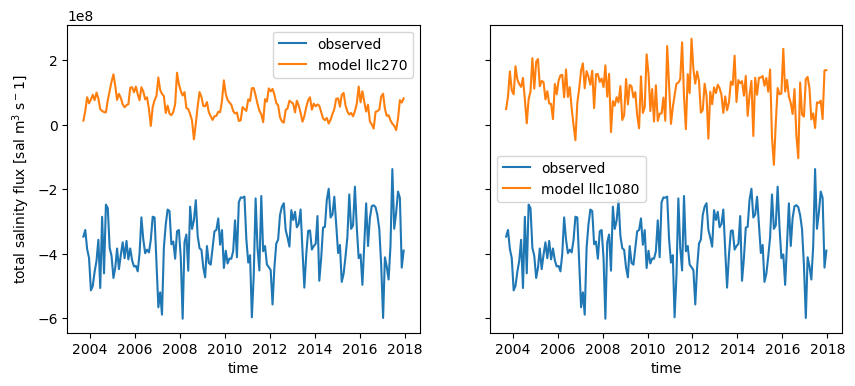

In [206]:
fig,ax = plt.subplots(ncols=2, nrows=1,figsize=(10,4),sharex=True,sharey=True,)

sal_flux_obs.sum(dim='k',skipna=True).sum(dim='x',skipna=True).plot(ax=ax[0],label='observed')
sal_flux_obs.sum(dim='k',skipna=True).sum(dim='x',skipna=True).plot(ax=ax[1],label='observed')

sal_flux_1080.sum(dim='k',skipna=True).sum(dim='x',skipna=True).plot(ax=ax[1],label='model llc1080')
sal_flux_270.sum(dim='k',skipna=True).sum(dim='x',skipna=True).plot(ax=ax[0],label='model llc270')
ax[0].set_ylabel('total salinity flux [sal m$^3$ s$^-1$]')
ax[0].legend()
ax[1].legend()
plt.savefig('./sal_flux_total_fram.png')

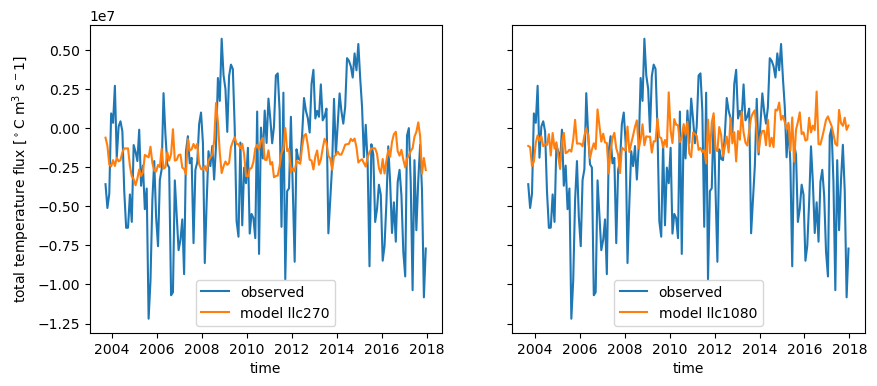

In [207]:
fig,ax = plt.subplots(ncols=2, nrows=1,figsize=(10,4),sharex=True,sharey=True,)

temp_flux_obs.sum(dim='k',skipna=True).sum(dim='x',skipna=True).plot(ax=ax[0],label='observed')
temp_flux_obs.sum(dim='k',skipna=True).sum(dim='x',skipna=True).plot(ax=ax[1],label='observed')

temp_flux_1080.sum(dim='k',skipna=True).sum(dim='x',skipna=True).plot(ax=ax[1],label='model llc1080')
temp_flux_270.sum(dim='k',skipna=True).sum(dim='x',skipna=True).plot(ax=ax[0],label='model llc270')
ax[0].set_ylabel('total temperature flux [$^\circ$C m$^3$ s$^-1$]')
ax[0].legend()
ax[1].legend()

plt.savefig('./temp_flux_total_fram.png')

In [192]:
fram_sub_uv_ts.to_netcdf('/media/basil/Elements/data/Fram/full_subsample_fram.nc')

## heat flux

In [208]:
import gsw
heat_obs = gsw.cp_t_exact(ds['Salinity_obs'], ds['Temperature_obs'], ds['depth']).rename('heat')
heat_270 = gsw.cp_t_exact(ds['Salinity_270'], ds['Temperature_270'], ds['depth']).rename('heat_270')
heat_1080 = gsw.cp_t_exact(ds['Salinity_1080'], ds['Temperature_1080'], ds['depth']).rename('heat_1080')

heat_obs.attrs = {'short_name': 'heat capacity of seawater',
 'long_name': 'heat capacity of seawater',
 'units': 'J*(kg*K)$^-1$'}
heat_270.attrs = {'short_name': 'heat capacity of seawater',
 'long_name': 'heat capacity of seawater',
 'units': 'J*(kg*K)$^-1$'}
heat_1080.attrs = {'short_name': 'heat capacity of seawater',
 'long_name': 'heat capacity of seawater',
 'units': 'J*(kg*K)$^-1$'}
density = gsw.pot_rho_t_exact(ds['Salinity_obs'], ds['Temperature_obs'], ds['depth'], 0)
density_270 = gsw.pot_rho_t_exact(ds['Salinity_270'], ds['Temperature_270'], ds['depth'], 0)
density_1080 = gsw.pot_rho_t_exact(ds['Salinity_1080'], ds['Temperature_1080'], ds['depth'], 0)


In [209]:
heat_flux_obs = heat_obs*area*vel_obs*(temp_obs+273.15)*density
heat_flux_270 = heat_270*area*vel_270*(temp_270+273.15)*density_270
heat_flux_1080 = heat_1080*area*vel_1080*(temp_1080+273.15)*density_1080

heat_flux_obs.attrs = {'short_name': 'heat flux of seawater',
 'long_name': 'heat flux of seawater',
 'units': 'J s$^-1$'}
heat_flux_270.attrs = {'short_name': 'heat flux of seawater',
 'long_name': 'heat capacity of seawater',
 'units': 'J s$^-1$'}
heat_flux_1080.attrs = {'short_name': 'heat flux of seawater',
 'long_name': 'heat flux of seawater',
 'units': 'J s$^-1$'}

In [210]:
tot_heat_flux_1080 = heat_flux_1080.sum(dim='k',skipna=True).sum(dim='x',skipna=True).rename('total_heat_flux_1080')
tot_heat_flux_270 = heat_flux_270.sum(dim='k',skipna=True).sum(dim='x',skipna=True).rename('total_heat_flux_270')
tot_heat_flux_obs = heat_flux_obs.sum(dim='k',skipna=True).sum(dim='x',skipna=True).rename('total_heat_flux_obs')

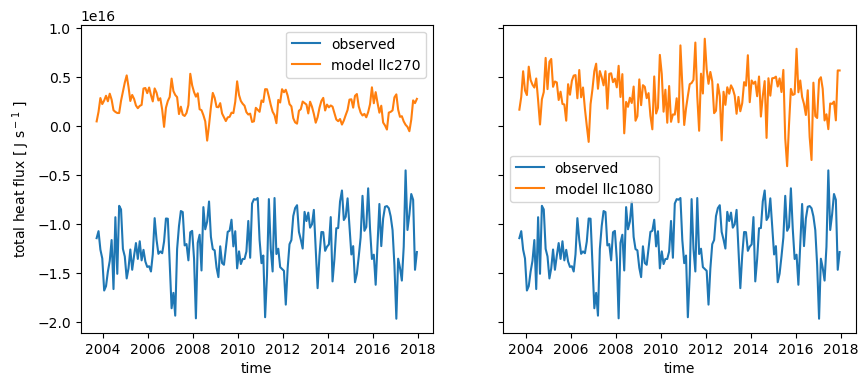

In [211]:
fig,ax = plt.subplots(ncols=2, nrows=1,figsize=(10,4),sharex=True,sharey=True,)

tot_heat_flux_obs.plot(ax=ax[0],label='observed')
tot_heat_flux_obs.plot(ax=ax[1],label='observed')

tot_heat_flux_1080.plot(ax=ax[1],label='model llc1080')
tot_heat_flux_270.plot(ax=ax[0],label='model llc270')
ax[0].set_ylabel('total heat flux [ J s$^-$$^1$ ]')
ax[1].set_ylabel('')

ax[0].legend()
ax[1].legend()

plt.savefig('./heat_flux_total_fram.png')